# Uncertainty Visualization: MODIS-Aqua Hypoxia Probabilities

This notebook visualizes the uncertainty (probability) raster for a specific MODIS-Aqua scene, providing:
- Spatial confidence mapping (probability and uncertainty heatmaps)
- Metadata inspection (CRS, resolution, extent, dtype)
- Statistical analysis (histogram, high/low confidence percentages)
- Confidence threshold masks (80%, 90%, 95%) and overlay with binary predictions
- Export of a publication-quality figure with annotations

## 1. Load Required Libraries

Imports for raster I/O, visualization, and analysis. Optional cartopy adds geographic context (coastlines, projection).

In [2]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.plot import plotting_extent

# Optional geographic context (cartopy). If unavailable, the code still runs without it.
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    HAS_CARTOPY = True
except Exception:
    HAS_CARTOPY = False

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 2. Load Uncertainty Raster

Loads the uncertainty raster (uint8 0–255) for the specified MODIS-Aqua scene and extracts geospatial metadata.

In [3]:
# File path to uncertainty raster (update if different on your system)
uncertainty_path = r"C:\Users\hafez\MSU\Research\msGOM\mssound\bloom\data\probability\uncertainty\OCEANDATA_MODIS-Aqua_L3SMI2002-07-01_hypoxia_uncertainty.tif"

# Load raster and metadata
with rasterio.open(uncertainty_path) as src:
    data_u8 = src.read(1)  # uint8 0-255
    transform = src.transform
    crs = src.crs
    bounds = src.bounds
    res = src.res
    extent = plotting_extent(src)

# Convert to probability scale (0-1)
data_prob = data_u8.astype(np.float32) / 255.0

# Derive an uncertainty measure (highest near 0.5 probability)
# uncertainty = 1 - |p - 0.5|*2 → 1 at p=0.5, 0 at p=0 or 1
uncertainty = 1.0 - np.minimum(np.abs(data_prob - 0.5) * 2.0, 1.0)

print("✓ Loaded uncertainty raster:", os.path.basename(uncertainty_path))

✓ Loaded uncertainty raster: OCEANDATA_MODIS-Aqua_L3SMI2002-07-01_hypoxia_uncertainty.tif


## 3. Display Raster Metadata

Inspect key properties for context: shape, dtype, CRS, resolution, extent, and probability range.

In [4]:
print("=== Raster Metadata ===")
print(f"Shape: {data_u8.shape}")
print(f"Data type: {data_u8.dtype}")
print(f"CRS: {crs}")
print(f"Resolution: {res}")
print(f"Bounds: {bounds}")
print(f"Probability range: [{data_prob.min():.3f}, {data_prob.max():.3f}]\n")

=== Raster Metadata ===
Shape: (850, 1936)
Data type: uint8
CRS: EPSG:4326
Resolution: (0.008983152841195214, 0.008983152841195214)
Bounds: BoundingBox(left=-97.77263552356872, bottom=23.83230448769091, right=-80.38125162301479, top=31.46798440270684)
Probability range: [0.024, 0.400]



## 4. Visualize Uncertainty Map

- Left: Hypoxia probability (0–1)
- Right: Uncertainty (highest near 0.5 probability). Uses colormaps that highlight differences and aid interpretation.

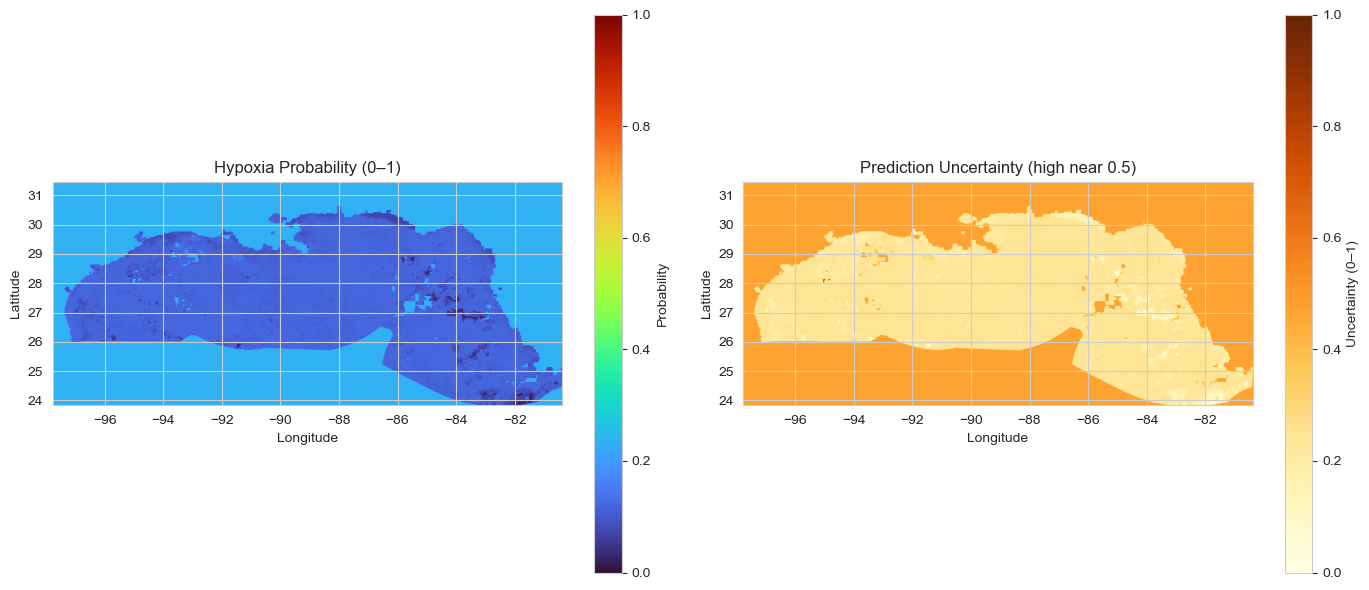

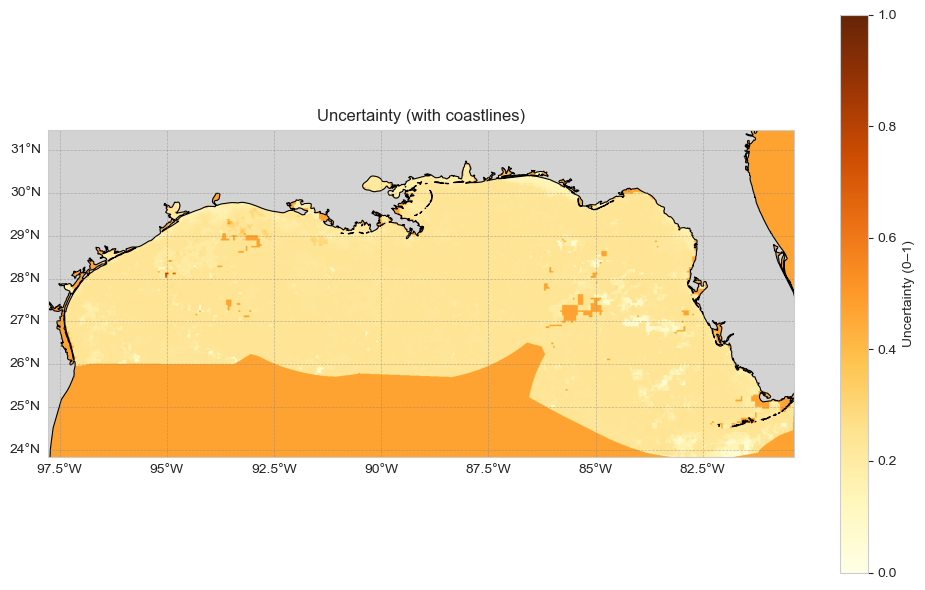

In [5]:
# Create side-by-side probability and uncertainty heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Probability map (hypoxia probability)
im0 = axes[0].imshow(data_prob, extent=extent, cmap='turbo', vmin=0, vmax=1)
axes[0].set_title('Hypoxia Probability (0–1)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
cbar0 = plt.colorbar(im0, ax=axes[0])
cbar0.set_label('Probability')

# Uncertainty map (peaks near 0.5 probability)
im1 = axes[1].imshow(uncertainty, extent=extent, cmap='YlOrBr', vmin=0, vmax=1)
axes[1].set_title('Prediction Uncertainty (high near 0.5)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
cbar1 = plt.colorbar(im1, ax=axes[1])
cbar1.set_label('Uncertainty (0–1)')

plt.tight_layout()
plt.show()

# Optional cartopy overlay (coastline)
if HAS_CARTOPY:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    im = ax.imshow(uncertainty, extent=extent, cmap='YlOrBr', vmin=0, vmax=1, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=2)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    plt.colorbar(im, ax=ax, orientation='vertical', label='Uncertainty (0–1)')
    ax.set_title('Uncertainty (with coastlines)', fontsize=12)
    plt.tight_layout()
    plt.show()

## 5. Statistical Analysis of Uncertainty

Compute summary stats, visualize histogram of the uint8 values, and report high-/low-confidence pixel percentages.

Mean probability: 0.177
Std probability:  0.062
Min/Max prob:     [0.024, 0.400]



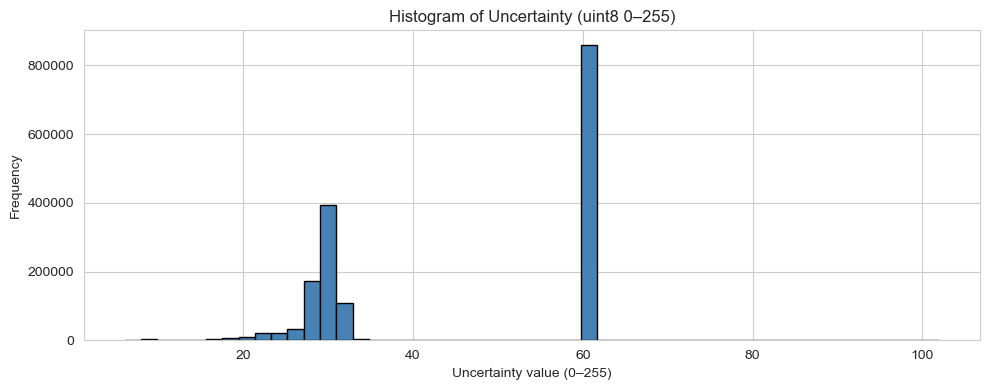

High-confidence pixels (>200 or <55): 47.8%
Low-confidence pixels (100–155):       0.0%


In [6]:
# Summary statistics
mean_prob = float(np.nanmean(data_prob))
std_prob = float(np.nanstd(data_prob))
min_prob = float(np.nanmin(data_prob))
max_prob = float(np.nanmax(data_prob))

print(f"Mean probability: {mean_prob:.3f}")
print(f"Std probability:  {std_prob:.3f}")
print(f"Min/Max prob:     [{min_prob:.3f}, {max_prob:.3f}]\n")

# Histogram of uint8 values (0-255)
plt.figure(figsize=(10, 4))
plt.hist(data_u8.ravel(), bins=50, color='steelblue', edgecolor='black')
plt.title('Histogram of Uncertainty (uint8 0–255)')
plt.xlabel('Uncertainty value (0–255)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# High-/low-confidence ranges
high_conf_mask = (data_u8 > 200) | (data_u8 < 55)
low_conf_mask = (data_u8 >= 100) & (data_u8 <= 155)

total_pixels = data_u8.size
pct_high_conf = 100.0 * np.count_nonzero(high_conf_mask) / total_pixels
pct_low_conf = 100.0 * np.count_nonzero(low_conf_mask) / total_pixels

print(f"High-confidence pixels (>200 or <55): {pct_high_conf:.1f}%")
print(f"Low-confidence pixels (100–155):       {pct_low_conf:.1f}%")

## 6. Confidence Threshold Analysis

Generate masks for >80%, >90%, and >95% confidence and visualize their spatial distributions. If a paired binary prediction is available, overlay to inspect stable vs uncertain regions.

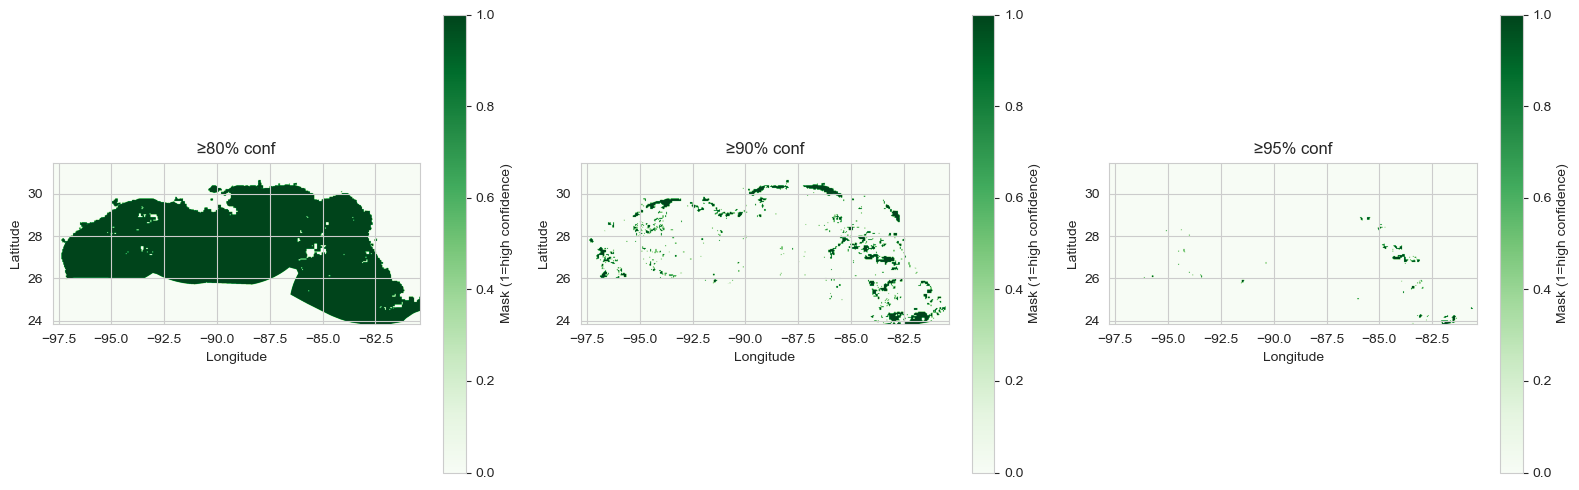

In [7]:
# Confidence masks based on probability
conf80 = (data_prob >= 0.80) | (data_prob <= 0.20)
conf90 = (data_prob >= 0.90) | (data_prob <= 0.10)
conf95 = (data_prob >= 0.95) | (data_prob <= 0.05)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for ax, mask, label in zip(axes, [conf80, conf90, conf95], ['≥80% conf', '≥90% conf', '≥95% conf']):
    im = ax.imshow(mask.astype(np.uint8), extent=extent, cmap='Greens')
    ax.set_title(label)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax, label='Mask (1=high confidence)')
plt.tight_layout()
plt.show()

# Optional: overlay with binary predictions if available
# pred_path = r"C:\\Users\\hafez\\MSU\\Research\\msGOM\\mssound\\bloom\\data\\Predicted rast\\OCEANDATA_MODIS-Aqua_L3SMI2002-07-01_hypoxia_pred.tif"
# try:
#     with rasterio.open(pred_path) as src:
#         pred = src.read(1)
#     stable_hypoxic_90 = (pred == 1) & conf90
#     plt.figure(figsize=(7, 5))
#     plt.imshow(stable_hypoxic_90.astype(np.uint8), extent=extent, cmap='Reds')
#     plt.title('Stable Hypoxic (binary=1) at ≥90% confidence')
#     plt.xlabel('Longitude'); plt.ylabel('Latitude')
#     plt.colorbar(label='Mask (1=stable hypoxic)')
#     plt.tight_layout(); plt.show()
# except Exception as e:
#     print('Overlay skipped:', e)

## 7. Export High-Resolution Figure

Save a publication-quality PNG with annotations. If cartopy is available, include coastlines; otherwise export the dual-panel uncertainty figure.

In [ ]:
# Output folder and filename
out_dir = r"C:\Users\hafez\MSU\Research\msGOM\mssound\bloom\data\figures"
os.makedirs(out_dir, exist_ok=True)
out_file = os.path.join(out_dir, "OCEANDATA_MODIS-Aqua_L3SMI2002-07-01_uncertainty.png")

# Create a single annotated figure for export
fig = plt.figure(figsize=(12, 7))
if HAS_CARTOPY:
    ax = plt.axes(projection=ccrs.PlateCarree())
    im = ax.imshow(uncertainty, extent=extent, cmap='YlOrBr', vmin=0, vmax=1, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=2)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
else:
    ax = plt.gca()
    im = ax.imshow(uncertainty, extent=extent, cmap='YlOrBr', vmin=0, vmax=1)
    ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')

cb = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
cb.set_label('Uncertainty (0–1)')

# Simple north arrow and scale bar proxies (annotation)
ax.annotate('N', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, fontweight='bold',
            ha='center', va='center', rotation=0)
ax.annotate('—— Scale ~100 km (approx)', xy=(0.6, 0.05), xycoords='axes fraction', fontsize=10)

plt.title('Prediction Uncertainty — MODIS-Aqua L3SMI 2002-07-01')
plt.tight_layout()
plt.savefig(out_file, dpi=400, bbox_inches='tight')
print('✓ Saved figure to:', out_file)